# Kansas Data Preprocessing

This notebook explores datasets from Kansas and uses radial flow models to calculate pressure data from injection data. The earthquake catalog is well-formatted without many changes

## First Part
The first part of the notebook process earthquake catalog data in Kansas

In [70]:
from orion_light.seismic_catalog import SeismicCatalog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import utm
import os
from sklearn.cluster import KMeans

In [12]:
# Setting path for the seismic catalog data
seismic_csv='../datasets_Jul_7/kansas/kansasSeismicDetection.csv'

In [71]:
# Using pandas to load csv file
seismic_dataset=pd.read_csv(seismic_csv)

In [72]:
# Reordering the seismic catalog data into the format that we want and save it
seismic_reordered=pd.DataFrame({'epoch':seismic_dataset.epoch,
                                'latitude': seismic_dataset.latitude,
                                'longitude': seismic_dataset.longitude,
                                'depth': seismic_dataset.depth,
                                'easting': seismic_dataset.easting,
                                'northing': seismic_dataset.northing,
                                'magnitude': seismic_dataset.magnitude
                               })
seismic_reordered.to_csv('../Temporal_Datasets/kansas/seismic.csv',index=None)

In [15]:
# plt.hist(seismic_reordered['depth'])

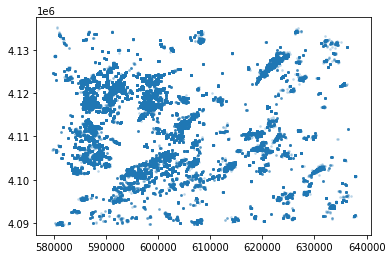

In [73]:
plt.scatter(seismic_reordered['easting'],seismic_reordered['northing'],s=3,alpha=0.2)

In [17]:
np.mean(seismic_reordered['easting']), np.mean(seismic_reordered['northing'])

(599912.5224646326, 4114169.4349210975)

In [114]:
kmeans = KMeans(n_clusters=8)
k_means_results = kmeans.fit_predict(seismic_reordered[['easting','northing']])

In [115]:
k_means_results

array([3, 2, 2, ..., 3, 1, 3], dtype=int32)

In [116]:
seismic_reordered['kmeans'] = k_means_results

In [117]:
seismic_reordered_set1 = seismic_reordered.loc[seismic_reordered['kmeans']==1]
seismic_reordered_set2 = seismic_reordered.loc[seismic_reordered['kmeans']==2]
seismic_reordered_set3 = seismic_reordered.loc[seismic_reordered['kmeans']==3]
seismic_reordered_set4 = seismic_reordered.loc[seismic_reordered['kmeans']==4]
seismic_reordered_set5 = seismic_reordered.loc[seismic_reordered['kmeans']==5]
seismic_reordered_set6 = seismic_reordered.loc[seismic_reordered['kmeans']==6]
seismic_reordered_set7 = seismic_reordered.loc[seismic_reordered['kmeans']==7]
seismic_reordered_set8 = seismic_reordered.loc[seismic_reordered['kmeans']==0]

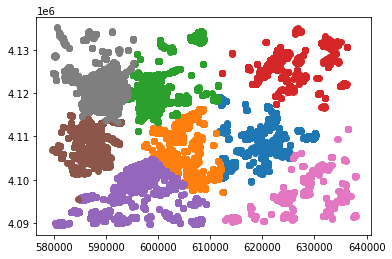

In [118]:
plt.scatter(seismic_reordered_set1['easting'],
            seismic_reordered_set1['northing'])
plt.scatter(seismic_reordered_set2['easting'],
            seismic_reordered_set2['northing'])
plt.scatter(seismic_reordered_set3['easting'],
            seismic_reordered_set3['northing'])
plt.scatter(seismic_reordered_set4['easting'],
            seismic_reordered_set4['northing'])
plt.scatter(seismic_reordered_set5['easting'],
            seismic_reordered_set5['northing'])
plt.scatter(seismic_reordered_set6['easting'],
            seismic_reordered_set6['northing'])
plt.scatter(seismic_reordered_set7['easting'],
            seismic_reordered_set7['northing'])
plt.scatter(seismic_reordered_set8['easting'],
            seismic_reordered_set8['northing'])

In [128]:
seismic_reordered_set1.drop(columns='kmeans')
seismic_reordered_set1.to_csv('../Temporal_Datasets/kansas/loc1/seismic.csv',index=None)
seismic_reordered_set2.drop(columns='kmeans')
seismic_reordered_set2.to_csv('../Temporal_Datasets/kansas/loc2/seismic.csv',index=None)
seismic_reordered_set3.drop(columns='kmeans')
seismic_reordered_set3.to_csv('../Temporal_Datasets/kansas/loc3/seismic.csv',index=None)
seismic_reordered_set4.drop(columns='kmeans')
seismic_reordered_set4.to_csv('../Temporal_Datasets/kansas/loc4/seismic.csv',index=None)
seismic_reordered_set5.drop(columns='kmeans')
seismic_reordered_set5.to_csv('../Temporal_Datasets/kansas/loc5/seismic.csv',index=None)
seismic_reordered_set6.drop(columns='kmeans')
seismic_reordered_set6.to_csv('../Temporal_Datasets/kansas/loc6/seismic.csv',index=None)
seismic_reordered_set7.drop(columns='kmeans')
seismic_reordered_set7.to_csv('../Temporal_Datasets/kansas/loc7/seismic.csv',index=None)
seismic_reordered_set8.drop(columns='kmeans')
seismic_reordered_set8.to_csv('../Temporal_Datasets/kansas/loc8/seismic.csv',index=None)

In [142]:
# Calculating the center of each reagion
loc1_x, loc1_y = np.mean(seismic_reordered_set1['easting']),np.mean(seismic_reordered_set1['northing'])

In [143]:
loc2_x, loc2_y = np.mean(seismic_reordered_set2['easting']),np.mean(seismic_reordered_set2['northing'])

In [144]:
loc3_x, loc3_y = np.mean(seismic_reordered_set3['easting']),np.mean(seismic_reordered_set3['northing'])

In [146]:
loc4_x, loc4_y = np.mean(seismic_reordered_set4['easting']),np.mean(seismic_reordered_set4['northing'])

In [151]:
loc5_x, loc5_y = np.mean(seismic_reordered_set5['easting']),np.mean(seismic_reordered_set5['northing'])

In [152]:
loc6_x, loc6_y = np.mean(seismic_reordered_set6['easting']),np.mean(seismic_reordered_set6['northing'])

In [153]:
loc7_x, loc7_y = np.mean(seismic_reordered_set7['easting']),np.mean(seismic_reordered_set7['northing'])

In [154]:
loc8_x, loc8_y = np.mean(seismic_reordered_set8['easting']),np.mean(seismic_reordered_set8['northing'])

## Second Part
The second part of the notebook focuses on the processing of the injection datasets in Kansas
### Loading Injection Dataset

In [18]:
## Restart the work using the new datasets
# Loading Injection data
injection_csv='../datasets_Jul_7/Kansas/kansasInjection.csv'
injection_dataset=pd.read_csv(injection_csv,header=None,delimiter=' ')

In [19]:
# Transposing the dataset
injection_dataset_transpose = injection_dataset.transpose()
injection_dataset_transpose.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1.451635e+09,0.003736,0.0,0.003736,0.003171,0.003344,0.004723,0.002922,0.004140,0.001564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003162,0.003364
1,1.454314e+09,0.003381,0.0,0.003381,0.002659,0.003129,0.003950,0.002801,0.004018,0.001027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,0.003382
2,1.456819e+09,0.003715,0.0,0.003715,0.002627,0.003344,0.004685,0.002922,0.004140,0.001398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003179,0.003825
3,1.459494e+09,0.003496,0.0,0.003496,0.002981,0.003237,0.004514,0.002861,0.004079,0.001378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003029,0.003676
4,1.462086e+09,0.003490,0.0,0.003490,0.002763,0.003344,0.004705,0.002861,0.004140,0.001508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003141,0.003469


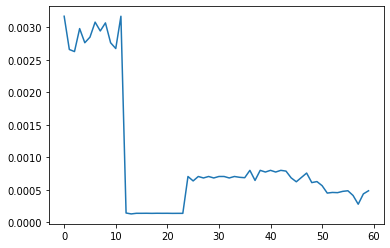

In [20]:
plt.plot(injection_dataset_transpose[4])

### Loading datasets with site information

In [21]:
# Loading site locations
site_csv = pd.read_csv('../datasets_Jul_7/kansas/kansas_well_apiLocation.txt',delimiter=' ')
site_csv.head()

,api,lat,lon
0,15077001230001,37.325,-98.248
1,15077010450002,37.124,-98.014
2,15077010820000,37.321,-98.256
3,15077100640001,37.362,-98.236
4,15077200120001,37.306,-98.214


In [22]:
from orion_light.seismic_catalog import SeismicCatalog

In [23]:
# Manually using calculate utm coordinates function
import utm
def calculate_utm_coordinates(latitude, longitude):
    """
    Convert catalog lat/lon coordinates to UTM
    """
    tmp = utm.from_latlon(latitude, longitude)
    easting = tmp[0]
    northing = tmp[1]
    utm_zone = str(tmp[2]) + tmp[3]
    return easting, northing, utm_zone

In [24]:
x = np.zeros(len(site_csv['lat']))
y = np.zeros(len(site_csv['lon']))
z = np.zeros(len(site_csv['lon'])) # all zeros
utm_list = [str(x) for x in site_csv['lat']]
for i in range(len(site_csv['lat'])):
    x[i],y[i],utm_list[i] = calculate_utm_coordinates(
        site_csv['lat'][i],site_csv['lon'][i])

In [25]:
locations_kansas = pd.DataFrame(x,columns=['x'])

In [26]:
locations_kansas['y'] = y
locations_kansas['z'] = z
locations_kansas['utms'] = utm_list

In [27]:
# storing locations in Kansas to an external file
locations_kansas.to_csv('../Temporal_Datasets/Kansas/locations.csv',index=None)

In [28]:
# Calculate for the first well
index = 0
epochs = injection_dataset_transpose[index]
x_loc = x[index]
y_loc = y[index]
z_loc = y[index]

In [29]:
# Getting epochs data
epochs = np.array(epochs)

In [30]:
# Add injection data to the dataframe locations_kansas as 'q'
(np.array(injection_dataset[1:])).shape
locations_kansas['q'] = np.array(injection_dataset[1:]).tolist()

In [31]:
# Show epochs data
injection_dataset_transpose[0].head()

0    1.451635e+09
1    1.454314e+09
2    1.456819e+09
3    1.459494e+09
4    1.462086e+09
Name: 0, dtype: float64

In [32]:
# saving wells in the format as used in well_tests.py
wells=[]
for index in range(len(locations_kansas.x)):
    wells.append({'x':locations_kansas.x[index],'y':locations_kansas.y[index],'z':locations_kansas.z[index],
                  't':epochs,'q':locations_kansas['q'][index]})

Text(0, 0.5, 'Northing (m)')

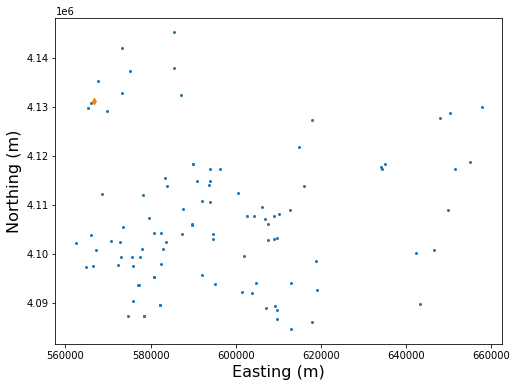

In [33]:
# wells location in Kansas
wells_idx = 0
fig = plt.figure(figsize=(8,6))
plt.scatter(x,y,marker='o',s=4)
plt.scatter(x[wells_idx],y[wells_idx],marker='d',s=20) # Labelling the first well in Kansas/
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)

In [35]:
from orion_light import radial_flow, pressure_table
flow_model = radial_flow.RadialFlowModel()
flow_model.viscosity = 1.0
flow_model.permeability = 194.5 
flow_model.storativity = 0.0014 
flow_model.payzone_thickness = 500.0
flow_model.setup_model(wells)

x_list = np.linspace(np.min(x),np.max(x),100)
y_list = np.linspace(np.min(y),np.max(y),100)
z_list = np.array([0.0,100.0])
t_list = np.linspace(epochs[0],epochs[-1],num=200)
G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')


In [38]:
G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')

In [45]:
output_root = "../Temporal_Datasets/kansas/wells"
os.makedirs(output_root,exist_ok=True)

In [46]:
np.savetxt(os.path.join(output_root,'x.csv'),x_list,delimiter=',')
np.savetxt(os.path.join(output_root,'y.csv'),y_list,delimiter=',')
np.savetxt(os.path.join(output_root,'z.csv'),z_list,delimiter=',')
np.savetxt(os.path.join(output_root,'t.csv'),t_list,delimiter=',')

In [47]:
pressure_flat = np.reshape(p,(-1),order='F')
np.savetxt(os.path.join(output_root,'pressure.csv'),pressure_flat,delimiter=',')

In [39]:
# p = flow_model(*G)

In [48]:
pressure_table = pressure_table.PressureTableModel()
data = {k: np.loadtxt(os.path.join(output_root, '%s.csv' % (k))) for k in ['x', 'y', 'z', 't', 'pressure']}
pressure_table.load_array(**data)

In [61]:
# t_scale = 60.0 * 60.0 * 24.0
# x_list = np.linspace(np.min(x),np.max(x),20)
# y_list = np.linspace(np.min(y),np.max(y),20)
# z_list = np.array([0.0,100.0])
# t_list = np.linspace(epochs[0],epochs[-1],num=200)
# G = np.meshgrid(x_list,y_list,z_list,t_list,indexing='ij')
p = pressure_table.p(*G)

In [62]:
dpdt = pressure_table.dpdt(*G)

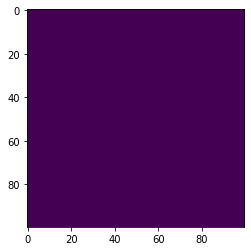

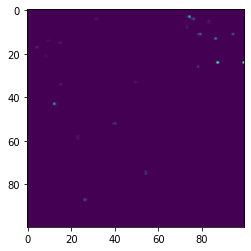

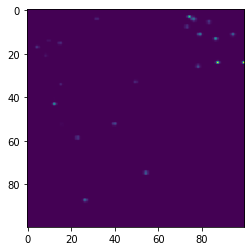

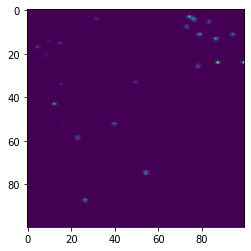

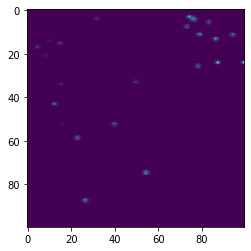

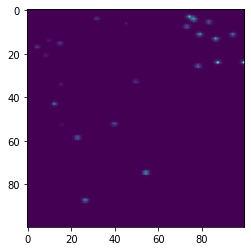

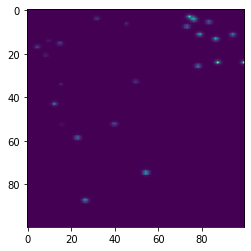

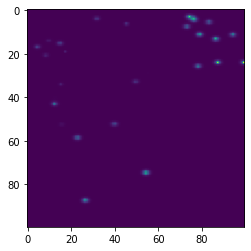

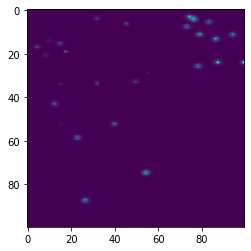

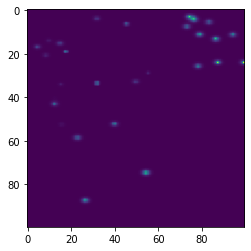

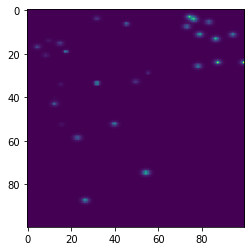

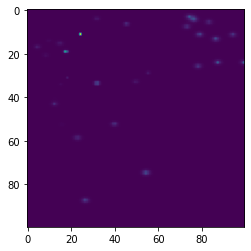

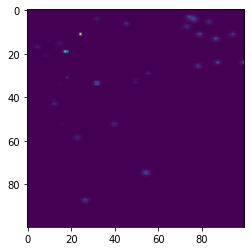

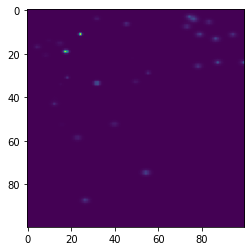

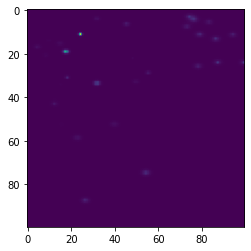

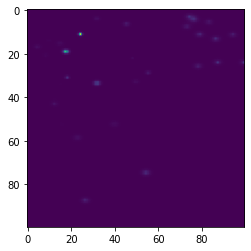

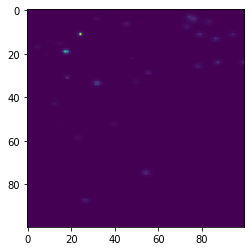

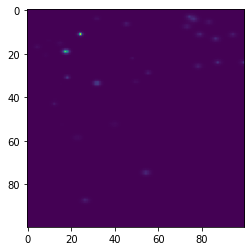

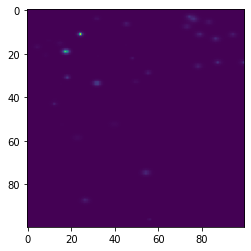

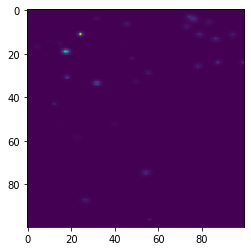

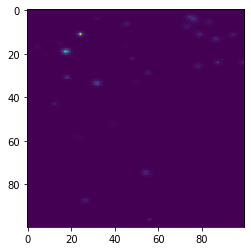

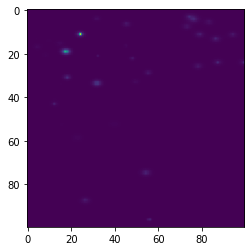

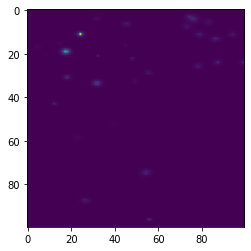

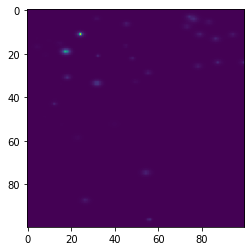

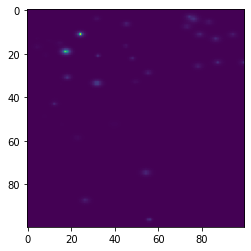

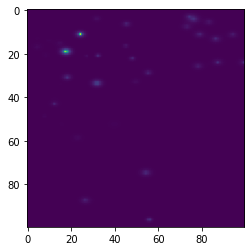

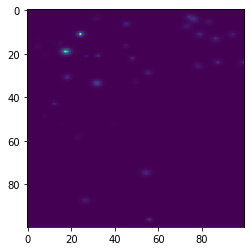

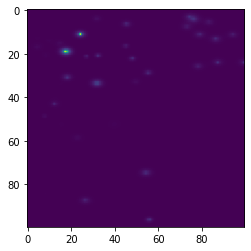

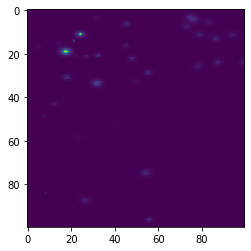

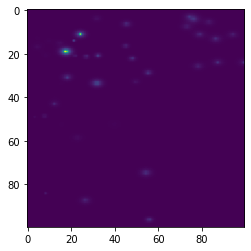

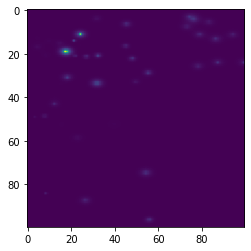

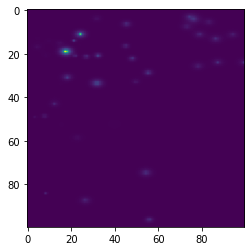

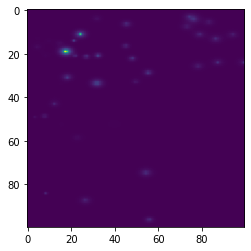

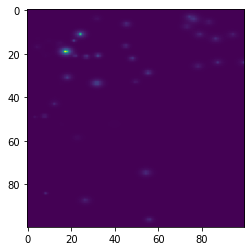

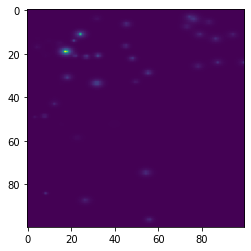

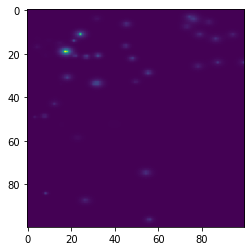

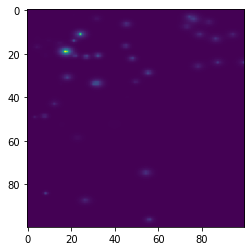

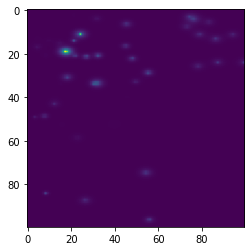

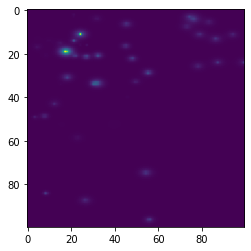

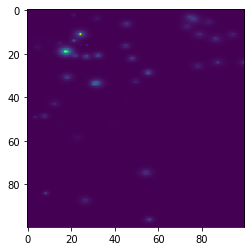

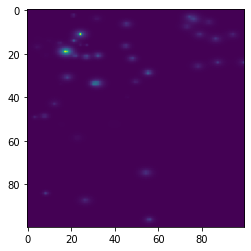

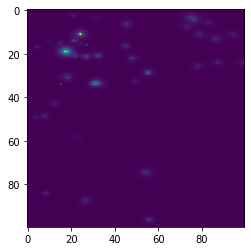

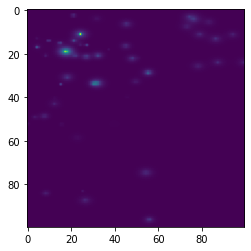

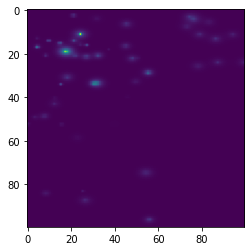

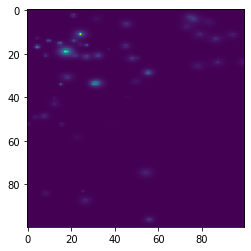

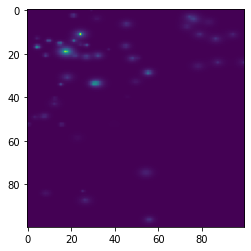

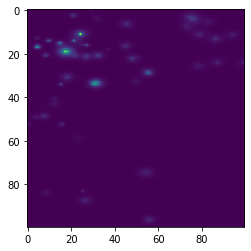

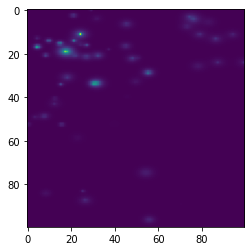

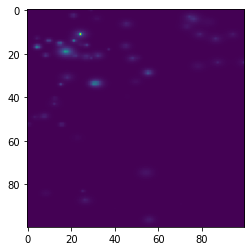

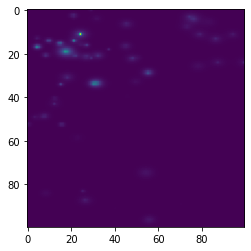

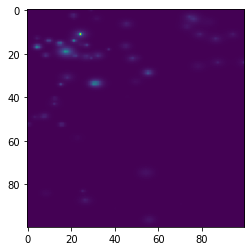

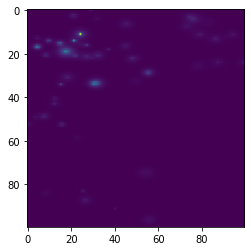

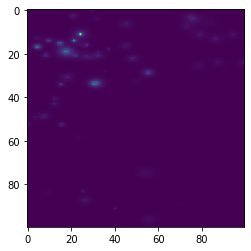

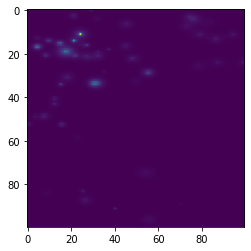

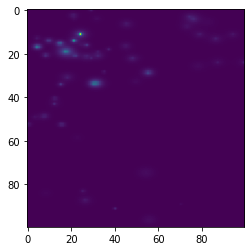

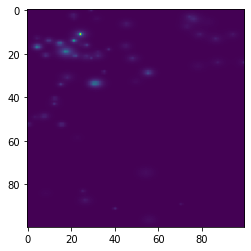

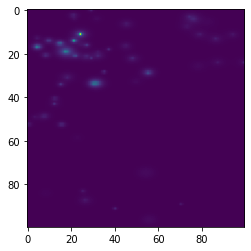

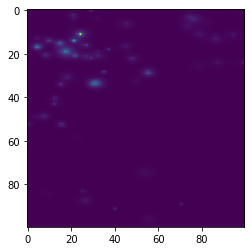

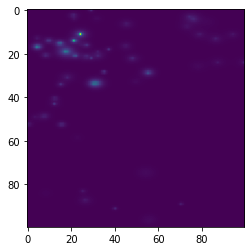

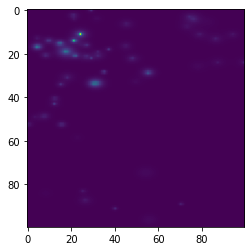

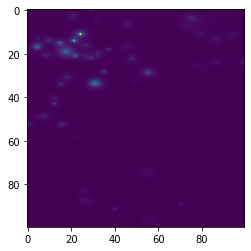

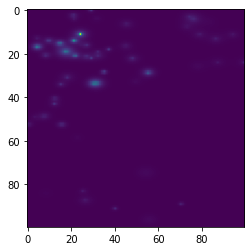

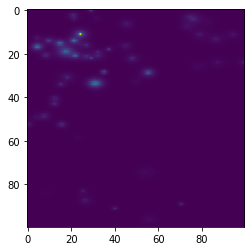

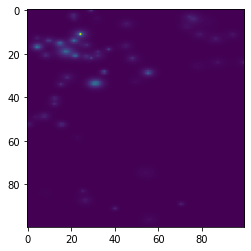

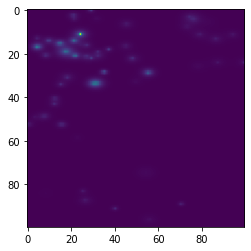

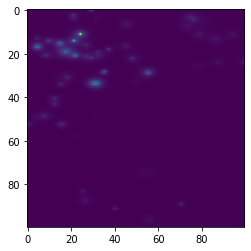

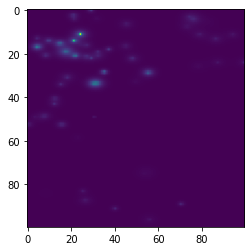

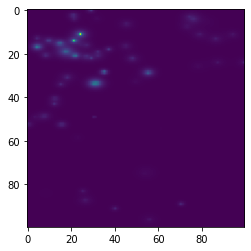

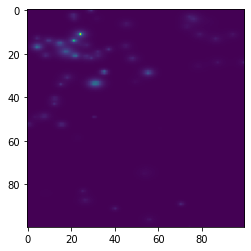

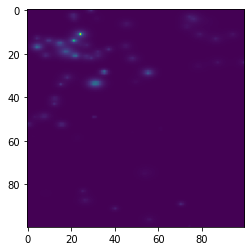

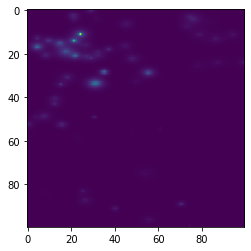

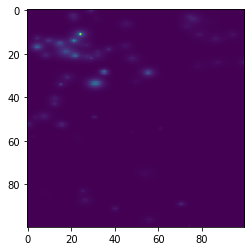

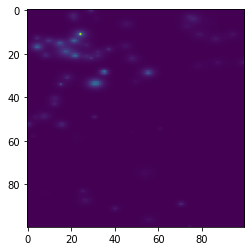

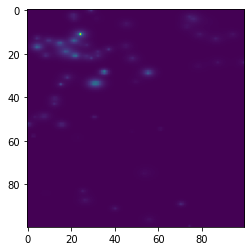

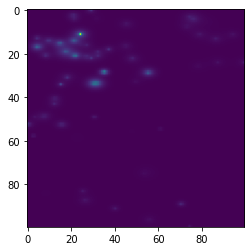

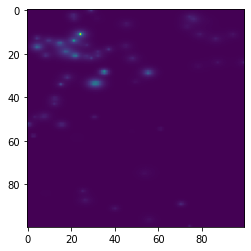

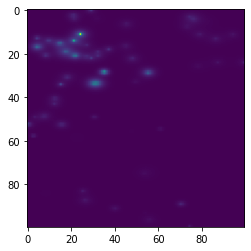

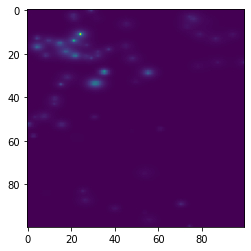

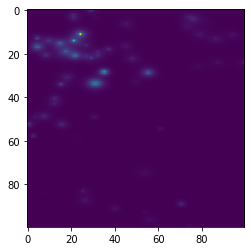

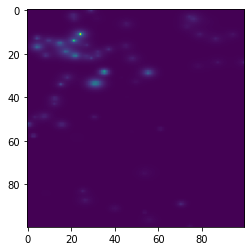

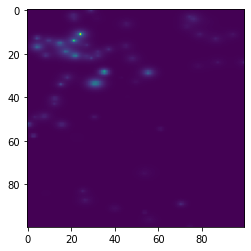

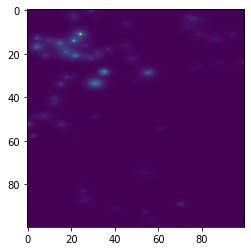

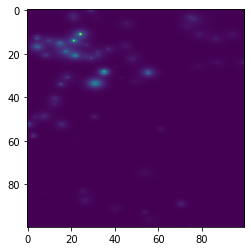

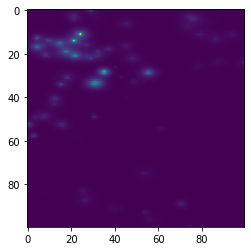

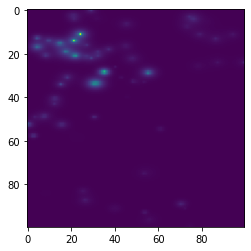

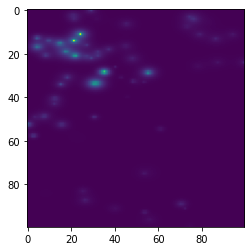

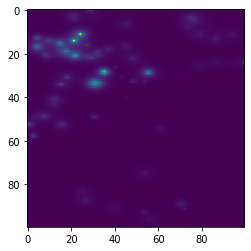

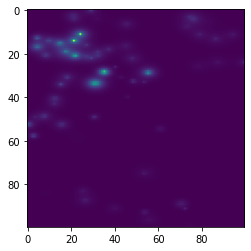

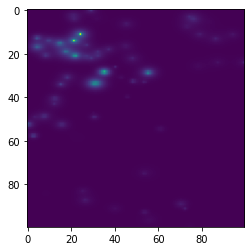

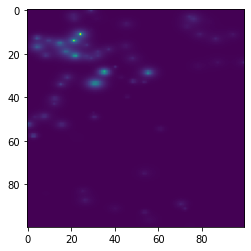

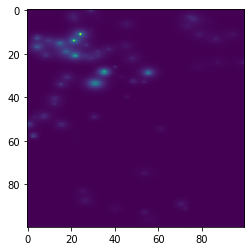

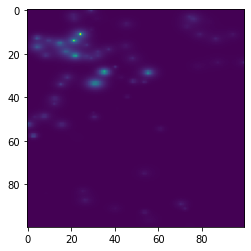

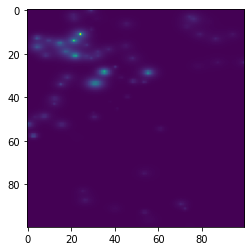

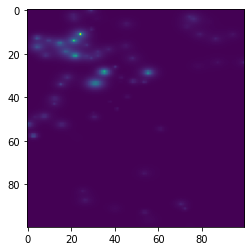

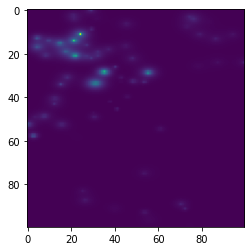

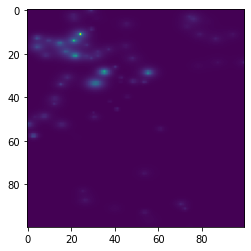

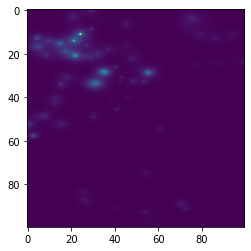

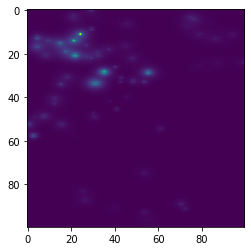

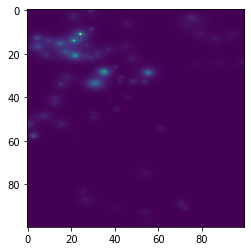

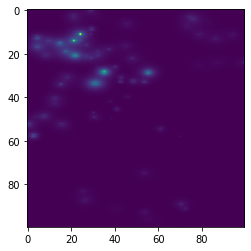

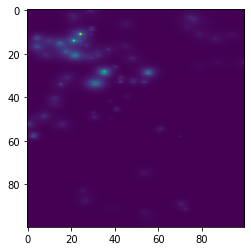

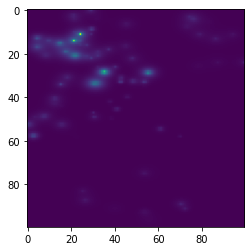

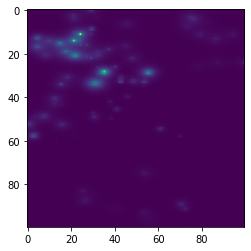

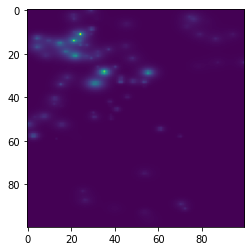

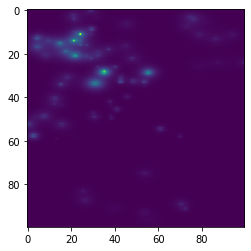

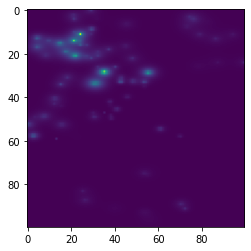

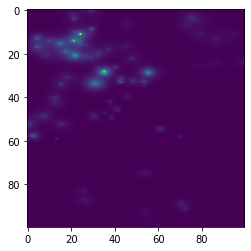

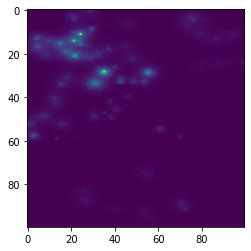

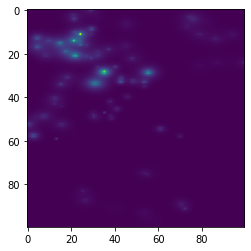

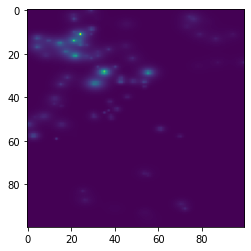

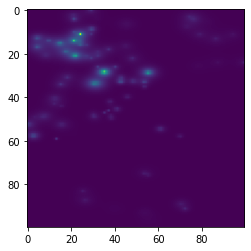

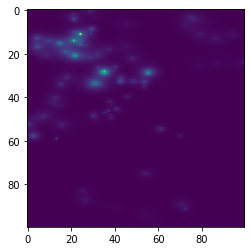

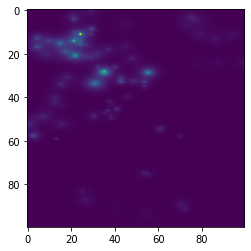

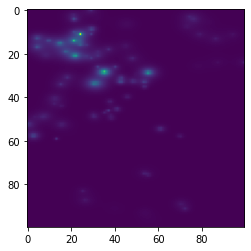

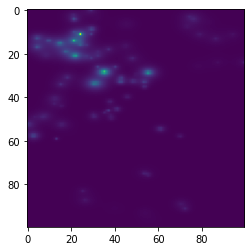

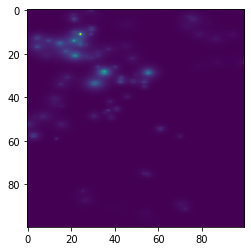

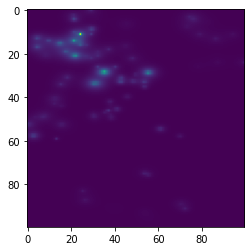

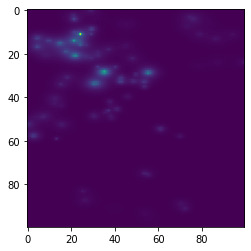

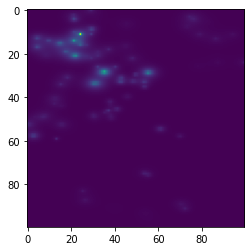

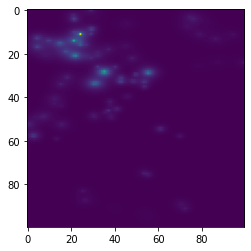

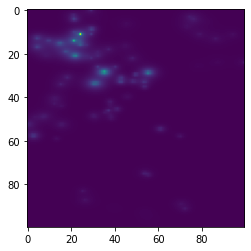

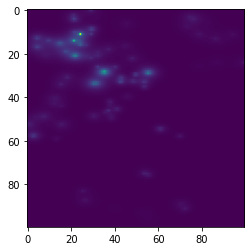

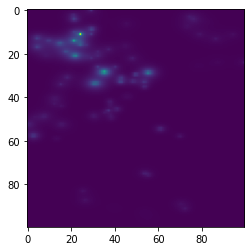

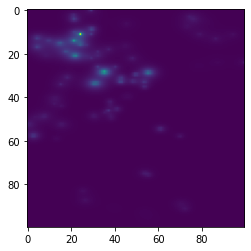

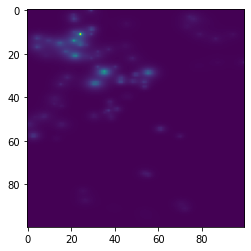

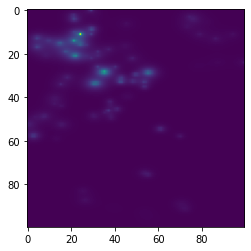

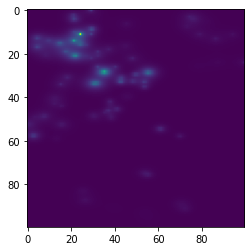

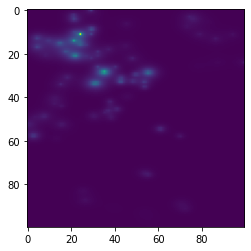

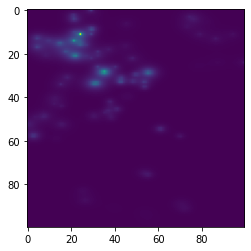

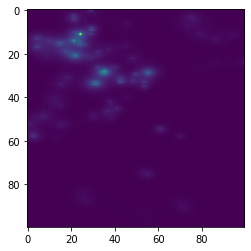

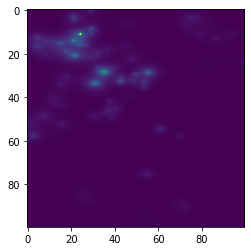

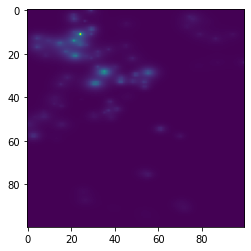

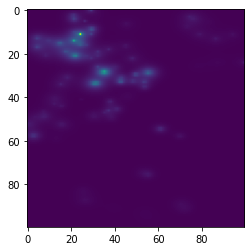

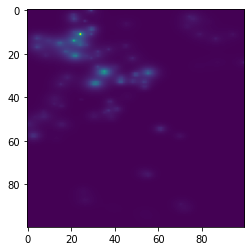

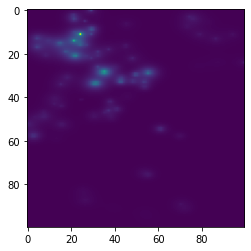

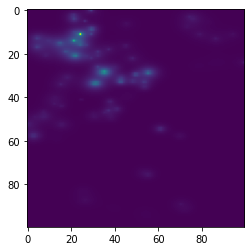

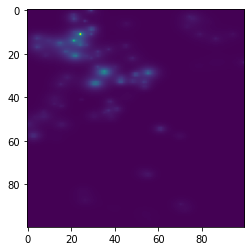

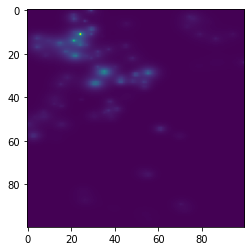

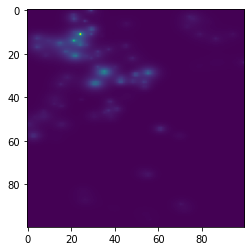

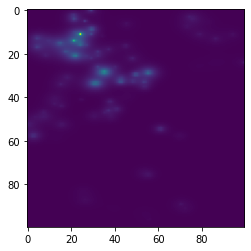

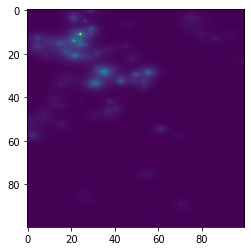

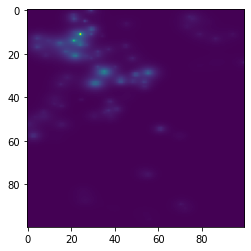

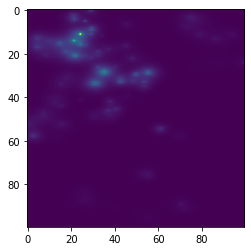

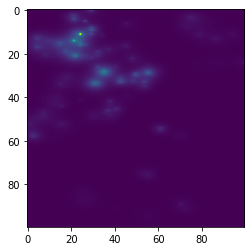

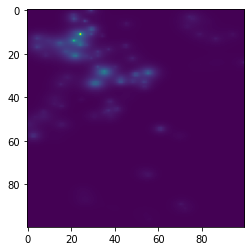

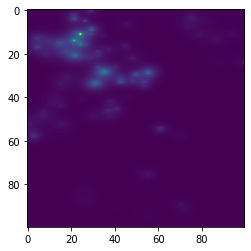

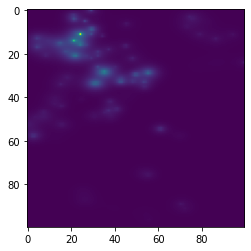

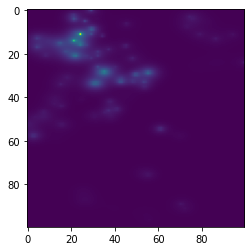

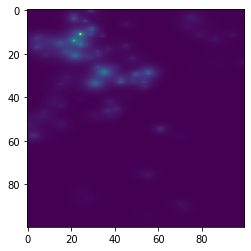

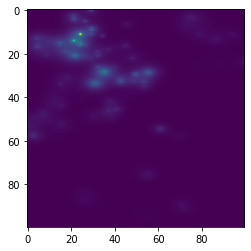

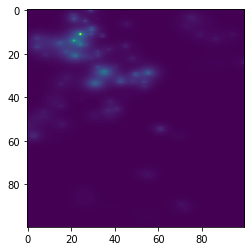

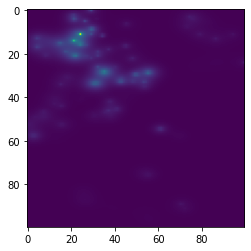

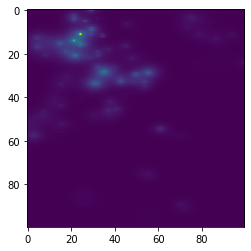

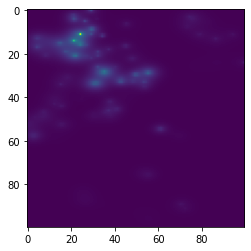

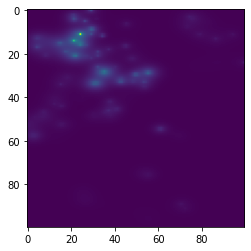

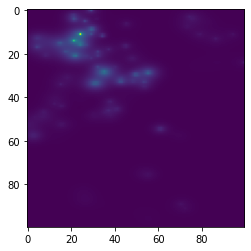

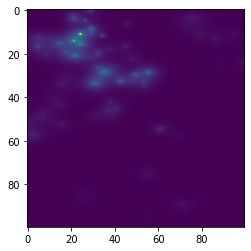

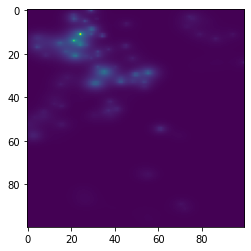

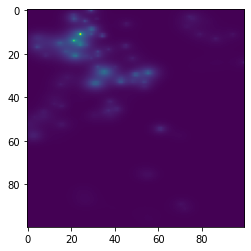

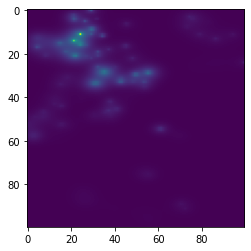

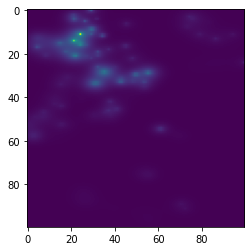

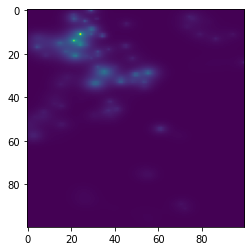

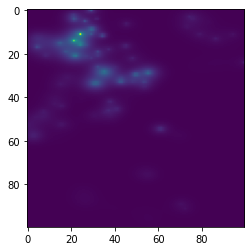

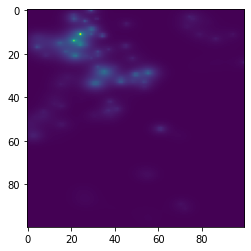

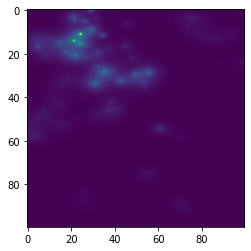

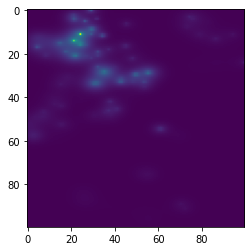

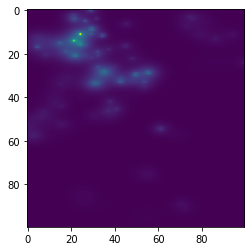

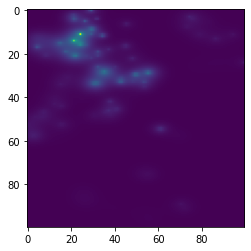

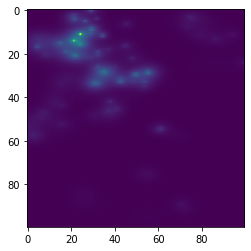

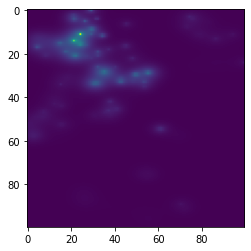

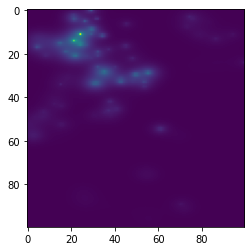

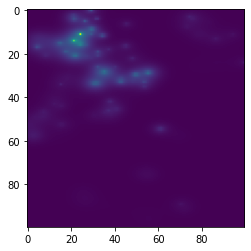

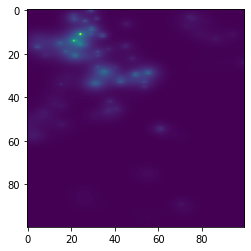

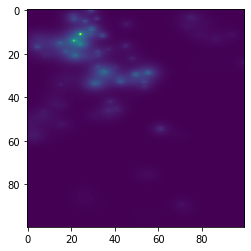

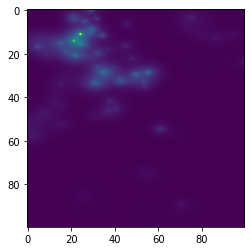

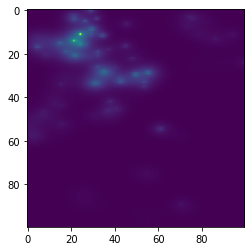

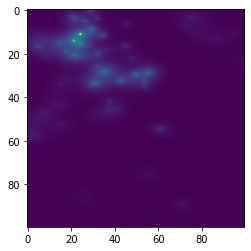

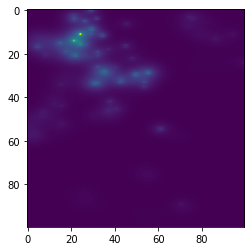

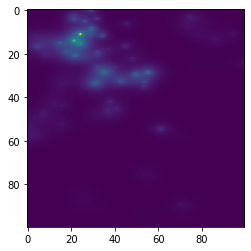

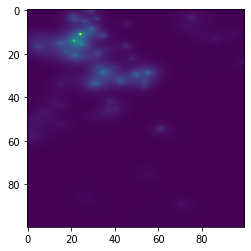

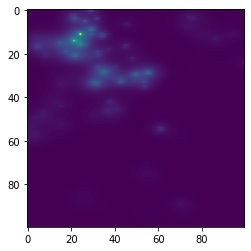

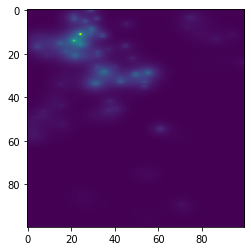

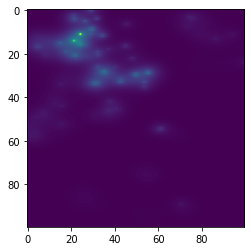

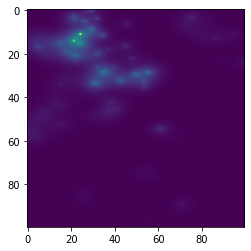

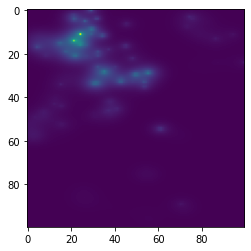

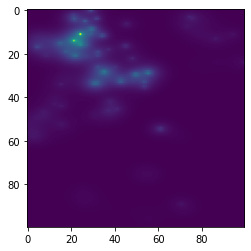

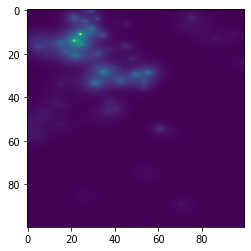

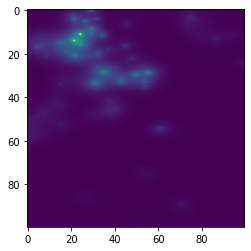

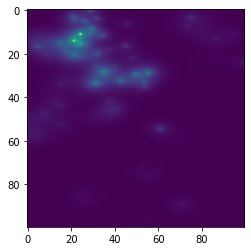

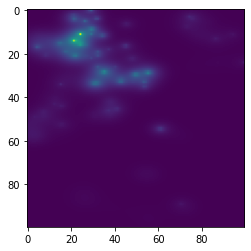

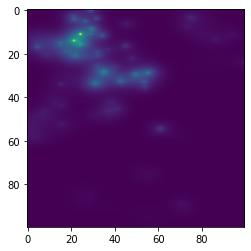

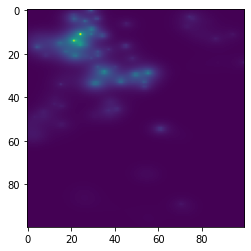

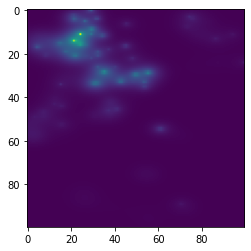

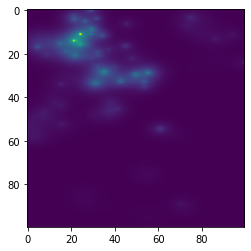

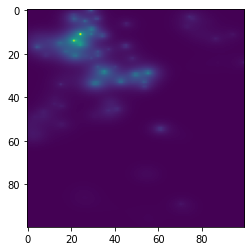

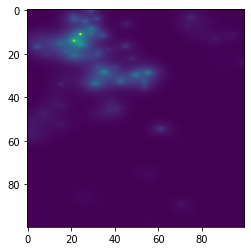

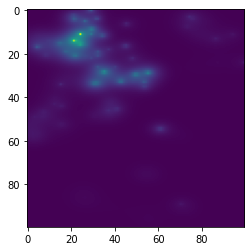

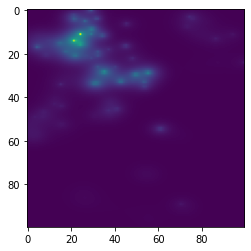

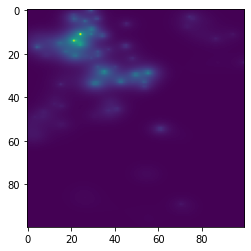

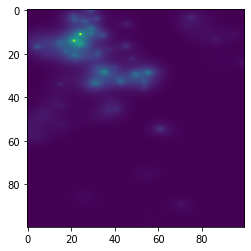

In [69]:
p_b = np.squeeze(p[:,:,0,12])
# plt.contour(x_list,y_list,p_b)
# Tricontour plot 
# scatter plot
plt.imshow(p_b)

for i in range(0,200):
    plt.imshow(np.squeeze(p[:,:,0,i]))
    plt.show()

Text(0, 0.5, 'Pressurization Rate')

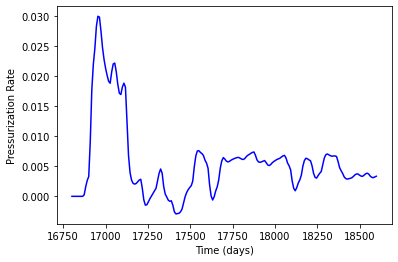

In [56]:
plt.figure()
p_b = np.squeeze(dpdt[18,18,0,:])
plt.plot(np.squeeze(t_list) / t_scale, p_b,'b')
plt.xlabel('Time (days)')
plt.ylabel('Pressurization Rate')

In [43]:
for i in range(0,20):
    for j in range(0,20):
        output_root = "../Temporal_Datasets/kansas/grid_points/grid_point_"+str(i)+'_'+str(j)
        os.makedirs(output_root)
        injection_cat = pd.DataFrame({
            'epoch': t_list,
#             'injection': injection_dataset
            'pressure': p[i,j,0,:],
            'dpdt': dpdt[i,j,0,:]
        })
        injection_cat.to_csv(output_root+str('/injection.csv'),index=None)

FileExistsError: [Errno 17] File exists: '../Temporal_Datasets/kansas/grid_points/grid_point_0_0'

In [ ]:
i = j = 0
injection_cat = pd.DataFrame({
            'epoch': t_list,
#             'injection': injection_dataset
            'pressure': p[i,j,0,:],
            'dpdt': dpdt[i,j,0,:]
        })

output_root = "../Temporal_Datasets/kansas/grid_point"+str(i)+str(j)

In [ ]:
injection_cat.to_csv()

In [ ]:
injection_cat.to_csv(output_root,index=None)

In [ ]:
x_list[4]
y_list[4]

In [ ]:
p_center = p[4,4,0,:]
plt.plot(p_center)

In [ ]:
dpdt_center = dpdt[4,4,0,:]
plt.plot(dpdt_center)

In [ ]:
injection = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_center,
    'dpdt': dpdt_center
})

In [ ]:
injection.to_csv('../Temporal_Datasets/kansas/pressure.csv',index=None)

array([562409.24097577, 563372.31471752, 564335.38845928, 565298.46220103,
       566261.53594279, 567224.60968455, 568187.6834263 , 569150.75716806,
       570113.83090982, 571076.90465157, 572039.97839333, 573003.05213509,
       573966.12587684, 574929.1996186 , 575892.27336036, 576855.34710211,
       577818.42084387, 578781.49458562, 579744.56832738, 580707.64206914,
       581670.71581089, 582633.78955265, 583596.86329441, 584559.93703616,
       585523.01077792, 586486.08451968, 587449.15826143, 588412.23200319,
       589375.30574495, 590338.3794867 , 591301.45322846, 592264.52697021,
       593227.60071197, 594190.67445373, 595153.74819548, 596116.82193724,
       597079.895679  , 598042.96942075, 599006.04316251, 599969.11690427,
       600932.19064602, 601895.26438778, 602858.33812954, 603821.41187129,
       604784.48561305, 605747.5593548 , 606710.63309656, 607673.70683832,
       608636.78058007, 609599.85432183, 610562.92806359, 611526.00180534,
       612489.0755471 , 6

In [163]:
loc1_xidx = np.abs(loc1_x - x_list).argmin()
loc1_yidx = np.abs(y_list - loc1_y).argmin()
p_1 = np.squeeze(p[loc1_xidx,loc1_yidx,0,:])
dpdt_1 = np.squeeze(dpdt[loc1_xidx,loc1_yidx,0,:])

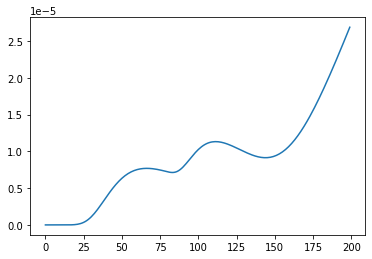

In [173]:
# plt.plot(p_1)
plt.plot(dpdt_1)
pressure_1 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_1,
    'dpdt': dpdt_1
})
pressure_1.to_csv('../Temporal_Datasets/kansas/loc1/pressure.csv',index=None)

In [166]:
loc2_xidx = np.abs(x_list - loc2_x).argmin()
loc2_yidx = np.abs(y_list - loc2_y).argmin()
p_2 = np.squeeze(p[loc2_xidx,loc2_yidx,0,:])
dpdt_2 = np.squeeze(dpdt[loc2_xidx,loc2_yidx,0,:])

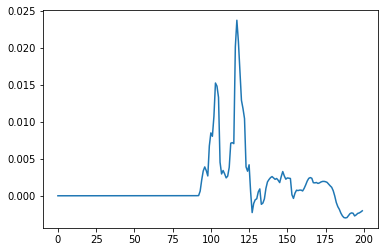

In [174]:
# plt.plot(p_2)
plt.plot(dpdt_2)
pressure_2 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_2,
    'dpdt': dpdt_2
})
pressure_2.to_csv('../Temporal_Datasets/kansas/loc2/pressure.csv',index=None)

In [175]:
loc3_xidx = np.abs(x_list - loc3_x).argmin()
loc3_yidx = np.abs(y_list - loc3_y).argmin()
p_3 = np.squeeze(p[loc3_xidx,loc3_yidx,0,:])
dpdt_3 = np.squeeze(dpdt[loc3_xidx,loc3_yidx,0,:])
pressure_3 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_3,
    'dpdt': dpdt_3
})
pressure_3.to_csv('../Temporal_Datasets/kansas/loc3/pressure.csv',index=None)

In [176]:
loc4_xidx = np.abs(x_list - loc4_x).argmin()
loc4_yidx = np.abs(y_list - loc4_y).argmin()
p_4 = np.squeeze(p[loc4_xidx,loc4_yidx,0,:])
dpdt_4 = np.squeeze(dpdt[loc4_xidx,loc4_yidx,0,:])
pressure_4 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_4,
    'dpdt': dpdt_4
})
pressure_4.to_csv('../Temporal_Datasets/kansas/loc4/pressure.csv',index=None)

In [177]:
loc5_xidx = np.abs(x_list - loc5_x).argmin()
loc5_yidx = np.abs(y_list - loc5_y).argmin()
p_5 = np.squeeze(p[loc5_xidx,loc5_yidx,0,:])
dpdt_5 = np.squeeze(dpdt[loc5_xidx,loc5_yidx,0,:])
pressure_5 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_5,
    'dpdt': dpdt_5
})
pressure_5.to_csv('../Temporal_Datasets/kansas/loc5/pressure.csv',index=None)

In [178]:
loc6_xidx = np.abs(x_list - loc6_x).argmin()
loc6_yidx = np.abs(y_list - loc6_y).argmin()
p_6 = np.squeeze(p[loc6_xidx,loc6_yidx,0,:])
dpdt_6 = np.squeeze(dpdt[loc6_xidx,loc6_yidx,0,:])
pressure_6 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_6,
    'dpdt': dpdt_6
})
pressure_6.to_csv('../Temporal_Datasets/kansas/loc6/pressure.csv',index=None)

In [179]:
loc7_xidx = np.abs(x_list - loc7_x).argmin()
loc7_yidx = np.abs(y_list - loc7_y).argmin()
p_7 = np.squeeze(p[loc7_xidx,loc7_yidx,0,:])
dpdt_7 = np.squeeze(dpdt[loc7_xidx,loc7_yidx,0,:])
pressure_7 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_7,
    'dpdt': dpdt_7
})
pressure_7.to_csv('../Temporal_Datasets/kansas/loc7/pressure.csv',index=None)

In [180]:
loc8_xidx = np.abs(x_list - loc8_x).argmin()
loc8_yidx = np.abs(y_list - loc8_y).argmin()
p_8 = np.squeeze(p[loc8_xidx,loc8_yidx,0,:])
dpdt_8 = np.squeeze(dpdt[loc8_xidx,loc8_yidx,0,:])
pressure_8 = pd.DataFrame({
    'epoch': t_list,
    'pressure': p_8,
    'dpdt': dpdt_8
})
pressure_8.to_csv('../Temporal_Datasets/kansas/loc8/pressure.csv',index=None)